## EE512 – Applied Biomedical Signal Processing
# Practical session – Linear Models I
### Instructions
* This notebook provides all the questions of the practical session and the space to answer them. We recommend working directly here and then exporting the document as your report.
* Include any code used when addressing the questions, together with your answers.
* Please submit your report as a single PDF file.
* We recommend working in a group of 3–4 students; you must prepare one single report for the group (`name1_name2_name3_lab_LinearModelsI.pdf`), but every member needs to upload the same file individually.

In [41]:
%matplotlib widget

# Imports
import os
import json
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.regression.linear_model import yule_walker

from scipy.signal import lfilter

# File paths
fbci = os.path.join(os.getcwd(), 'data', 'bci.json')
fafs = os.path.join(os.getcwd(), 'data', 'AF_sync.dat')
fspc = os.path.join(os.getcwd(), 'data', 'speech.dat')
fbld = os.path.join(os.getcwd(), 'data', 'blood.dat')

### Experiment 1: classifying EEG signals
The file `/data/bci.mat` contains two data matrices, `left_hand` and `right_foot`, from a brain-computer interface (BCI) experiment. Each column in these matrices corresponds to a 2-second electroencephalography (EEG) recording (sampling frequency of 128 Hz) from the same electrode. The recordings in `left_hand` (respectively `right_foot`) were performed while the subject imagines a movement of the left hand (resp. right foot). The goal of the BCI experiment is to be able to “guess” what is being imagined based on the EEG signals alone.

We start by importing the signals (and removing their averages to better approximate our AR models):

In [42]:
with open(fbci, 'r') as f:
    jc = json.load(f)

eeg_lh = np.array(jc['left_hand'])
eeg_rf = np.array(jc['right_foot'])

eeg_lh -= np.mean(eeg_lh, axis=0, keepdims=True)
eeg_rf -= np.mean(eeg_rf, axis=0, keepdims=True)

#### AR model order
A useful first step to look for structure in the signals is estimating the AR model order of each signal. We define a function `ar_order` to fit models of different orders, obtain the model noise variance, and apply a specific criterion:

In [43]:
def ar_order(x, omax, Aff=0):
    """
    AR order estimation
    x: signal
    omax: maximum possible order
    Aff: 0 no graphic display; 1 display
    
    Returns:
    omdl: order estimated with MDL
    """
    
    nx = len(x)
    s = np.zeros((omax,))
    c = np.zeros((omax,))

    for k in range(omax):
        
        n = k+1
        
        ar_model = AutoReg(x, n, trend='n')
        ar_model_fit = ar_model.fit()
        sg2 = ar_model_fit.sigma2
        
        s[k] = sg2
        c[k] = nx * np.log(sg2) + 2 * (n + 1)

    if Aff == 1:
        plt.figure()
        plt.plot(range(1, omax+1), mdl, 'o-')
        plt.title('Criterion')
        plt.show()
        
    return np.argmin(c)+1, s, c

**Question 1.1.** What is the name of the criterion being applied in the function `ar_order` implemented above? How would you change the code to apply the Akaike Information Criterion (AIC) instead?

**Answer 1.1.** `The name of the criterion being applied is the Minimum Description Length (MDL). It is considered to be the best criterion when applied to short signals. The purpose of these criteria is to choose the model order.
In order to implement the Akaike Information criterion (AIC) instead of the MDL criterion we will need to modify the loop.
The code we had before calculated the MDL criterion value for each order n using the formula nx * np.log(sg2) + (n+1) * np.log(nx) and kept it in the array c. In this case, when using the AIC criterion we will just have to change the calculation of the criterion value c. This is what we will show in the code above:
c[k] = nx * np.log(sg2) + 2 * (n + 1)`

Let's look at the order estimate for an example signal, in a reasonable range up 20:

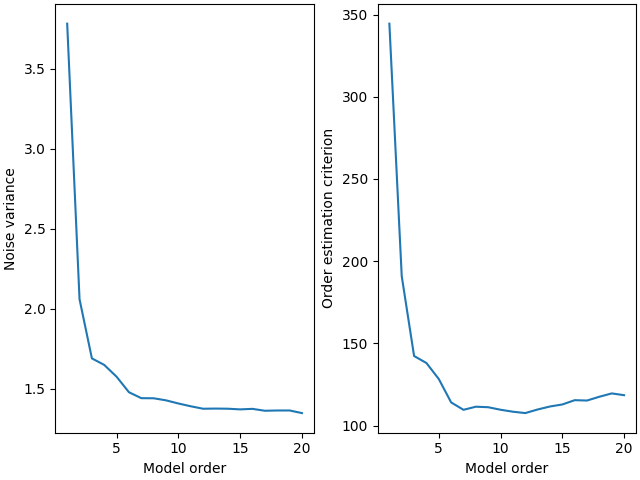

In [44]:
nmax = 20
_, s, c = ar_order(eeg_lh[:,1], nmax)

fig = plt.figure(constrained_layout=True)
n = np.arange(1, nmax+1)
plt.subplot(1,2,1)
plt.plot(n, s)
plt.xlabel('Model order')
plt.ylabel('Noise variance')
plt.subplot(1,2,2)
plt.plot(n, c)
plt.xlabel('Model order')
plt.ylabel('Order estimation criterion')
plt.show()

**Question 1.2.** Do the two curves obtained for this example signal behave as we would expect? What are their most important characteristics?

**Answer 1.2.** `Regarding the noise variance, it  generally takes smaller values as the order of the model gets bigger, which is what we can observe in the plot. This makes sense, because as the order of the model gets bigger, this means we are using more previous time steps to predict the current value of the signal. Consequently, there are more patterns captured, which will reduce the variability of the data.  Smaller noise variance means a more accurate fit of the model to the signal, but it is also important to take into account the complexity of the model and find a trade-off between both.
When it comes to the order estimation criteria, this value is minimized when we find the optimal model order. At this point, we will find the balance we had mentioned earlier. Before we get to the minimum value, the order estimation criteria is usually very high (as we can see in the plot), due to the fact that the model is too simple and the data is therefore under-fitted.`

We can now estimate and print the optimal model order for every signal of each condition:

In [45]:
nmax = 10

print("\nLeft hand :", end="")
for k in range(eeg_lh.shape[1]):
    n, _, _ = ar_order(eeg_lh[:,k], nmax)
    print("  {:02.0f}".format(n), end="")
print("")

print("Right foot:", end="")
for k in range(eeg_rf.shape[1]):
    n, _, _ = ar_order(eeg_rf[:,k], nmax)
    print("  {:02.0f}".format(n), end="")
print("\n")


Left hand :  09  07  07  09
Right foot:  08  10  08  03



**Question 1.3.** Based on these AR order estimates, is there already a difference between the two categories overall? And if we wish to perform AR model estimation using a common choice of model order for all signals, which value should be chosen, and why?

**Answer 1.3.** `We can see that the orders are different between both types of movements, where by calculating the average we have the minimum order for the left hand at 6.5 and for the right foot at 3.75. As we deal with natural integers, we could round them obtaining 7 and 4 indicating that both signals could be different. Consequently, for finding the common model order that suits the overall signal, we should minimize the order estimation criteria. Therefore, the way we proceed, we iterated among the different model orders, and calculated the overall average of the order estimation criterion. This indicated to us that the minimum average is reached with 4 as the model order.`

#### Movement prediction
We now look at the resulting AR coefficients when choosing a model order of `3`:

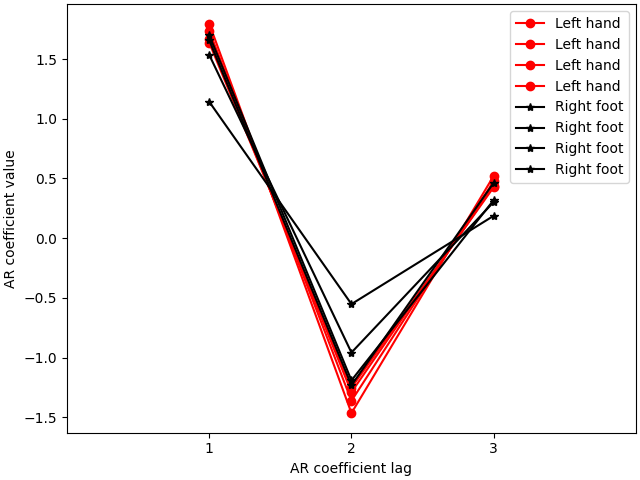

In [46]:
n = 3

fig = plt.figure(constrained_layout=True)

for k in range(eeg_lh.shape[1]):
    ar_model = AutoReg(eeg_lh[:,k], n, trend='n')
    ar_model_fit = ar_model.fit()
    plt.plot(range(1,4), ar_model_fit.params, 'ro-', label='Left hand')
    
for k in range(eeg_rf.shape[1]):
    ar_model = AutoReg(eeg_rf[:,k], n, trend='n')
    ar_model_fit = ar_model.fit()
    plt.plot(range(1,4), ar_model_fit.params, 'k*-', label='Right foot')
    
plt.legend()
plt.xticks(ticks=(1,2,3))
plt.xlabel('AR coefficient lag')
plt.ylabel('AR coefficient value')
plt.xlim(0,4)

plt.show()

**Question 1.4.** On which coefficients is the separation between categories most promising?

**Answer 1.4.** `For having a better idea, we do the average for each condition, left hand and right foot, and we see the distance between both values. As we can see, the highest distance is at the AR coefficient lag = 2. Therefore, this means that for this value, we can separate both signals better.`

### Experiment 2: AR model evolution over time
Real-life physiological signals can often vary substantially (and meaningfully) throughout a recording. It’s usually good practice to have a look at the data before trying to apply models. Consider the signal in `AF_sync.dat` – a recording of ECG atrial activity during atrial fibrillation (sampling frequency of 50 Hz). We start by importing the signal:

In [47]:
with open(fafs, 'r') as f:
    txt = f.readlines()
    af_sync = np.array([float(s[:-1]) for s in txt])
    
af_sync -= np.mean(af_sync)

#### Changes across time
Let's plot the signal and consider its evolution over the course of the recording. At the start (until sample ~2000 approximately), the signal is moderately organized; then it becomes very organized until sample ~3000. This probably corresponds to a drastic reduction in the number of fibrillatory waves in the atrial tissue (flutter). In the last part of the recording, the fibrillation, and thus the signal, becomes very disorganized.

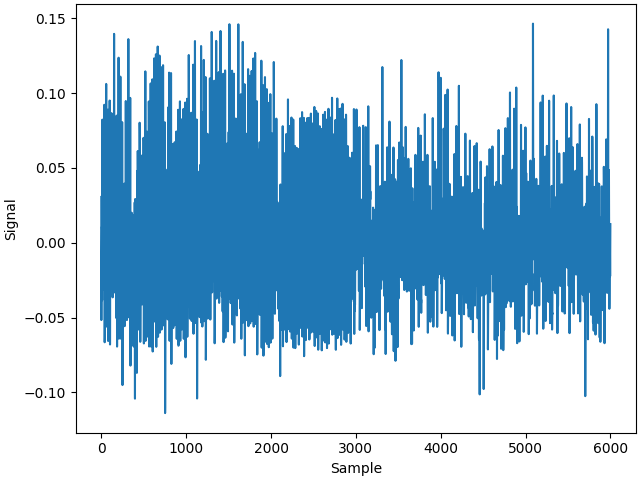

In [48]:
fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(af_sync)
plt.xlabel('Sample')
plt.ylabel('Signal')
plt.show()

**Question 2.1.** The code below is intended to plot the signal again and mark the three periods described above, but it is not yet complete. Make the necessary modifications to show all three periods of interest.

**Answer 2.1.**

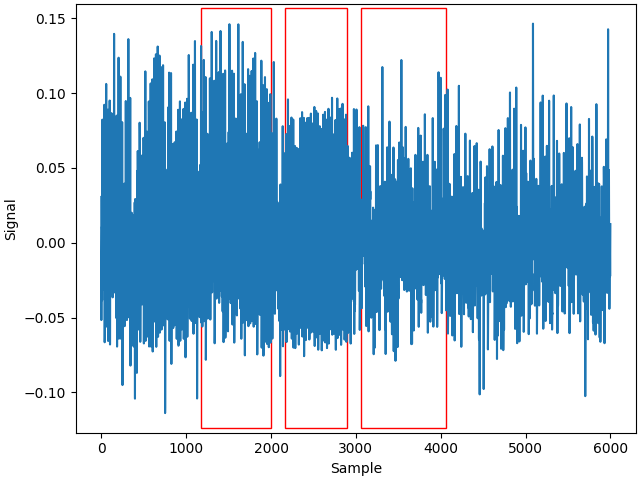

In [49]:
fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(af_sync)
plt.xlabel('Sample')
plt.ylabel('Signal')

segments = [[1170, 2000], [2170, 2890], [3060, 4060]]
eclr = [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]

for i in range(3):
    ax.axvspan(segments[i][0], segments[i][1], ymin=0.01, ymax=0.99, ec=eclr[0], fill=False)
    

plt.show()

#### Adaptive modeling
The clearly different states in `af_sync`, which vary across time, can be studied and modeled more quantitatively using a sliding-window approach. We thereby consider a segmentation of the signal into 500-sample windows with 50% overlap. For each segment, we can then estimate (i) the signal variance, (ii) optimal AR order, and (iii) the AR coefficients & excitation variance, as follows:

In [50]:
nw = 500
nv = round(nw*0.50)
nt = len(af_sync)

kt = []
ki, kf = 0, nw

# Getting the border and middle indices for each segment
while True:
    kt.append([ki, round(0.5*(ki+kf)), kf])
    ki += nw - nv
    kf += nw - nv
    if kf > nt: break

nc = len(kt)
arv = np.zeros((nc,))
aro = np.zeros((nc,), dtype=int)
arr = np.zeros((nc,))
nmax = 40

# Modeling the signal for each segment
for kc in range(nc):
    
    ys = af_sync[kt[kc][0]:kt[kc][2]]

    arv[kc] = np.var(ys)
    aro[kc], _, _ = ar_order(ys, nmax)
    
    _, sigma = yule_walker(ys, order=int(aro[kc]), method="mle")
    arr[kc] = sigma**2 / arv[kc]

We can then plot together the time evolution of the raw signal, the signal variance, the AR order, and the ratio of excitation variance to signal variance.

/tmp/ipykernel_111/3355400403.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(constrained_layout=True)


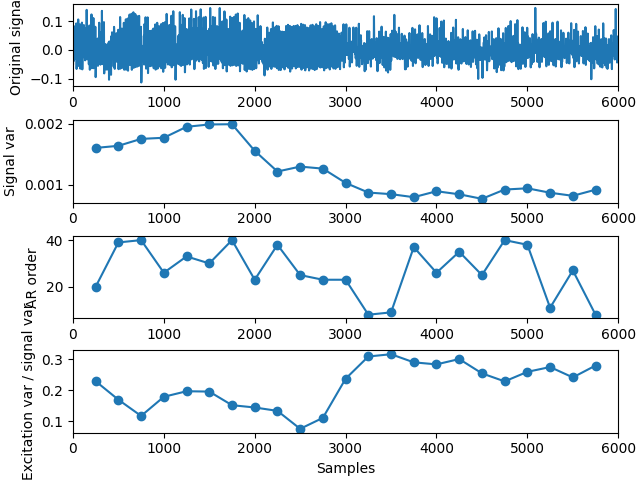

In [51]:
fig = plt.figure(constrained_layout=True)
t = np.array(kt)[:,1]

plt.subplot(4,1,1)
plt.plot(af_sync)
plt.ylabel('Original signal')
plt.xlim(0, len(af_sync))

plt.subplot(4,1,2)
plt.plot(t, arv, 'o-')
plt.ylabel('Signal var')
plt.xlim(0, len(af_sync))

plt.subplot(4,1,3)
plt.plot(t, aro, 'o-')
plt.ylabel('AR order')
plt.xlim(0, len(af_sync))

plt.subplot(4,1,4)
plt.plot(t, arr, 'o-')
plt.ylabel('Excitation var / signal var')
plt.xlim(0, len(af_sync))
plt.xlabel('Samples')

plt.show()

**Question 2.2.** Interpret the time evolution of the parameters plotted above, and how they relate to the organization of the signal in the three afore-mentioned stages.

**Answer 2.2.**  `In the early stage, the signal is moderately organized, leading to a certain level of variance and an AR order, finally the ratio is in the middle between its values for the other intervals, with an average of 0.2. In the middle stage, where the signal becomes more organized, there is a reduction in the variance, a slight increase in AR order, and a decrease in the ratio of excitation variance to signal variance. In fact, this ratio reaches its minimum in this part, and from here we can deduce that when a signal is organized, the excitation signal (error term) will be smaller. Additionally, this suggests that during flutter, the signal exhibits more predictable and structured behavior. In the last stage, during fibrillation, the signal becomes more disorganized, so the ratio reaches its maximum value. This leads to a decrease in signal variance and a drop of the model order, meaning that we could model the signal with a lower parameter, indicating that it behaves randomly as white noise.`

#### Signal stability and organization
Finally, another way of evaluating how organized a signal is, is by looking at its equivalent filter transfer function *H(z)* and the positioning of the corresponding poles. We can focus specifically on the three states defined previously in `segments`, as follows:

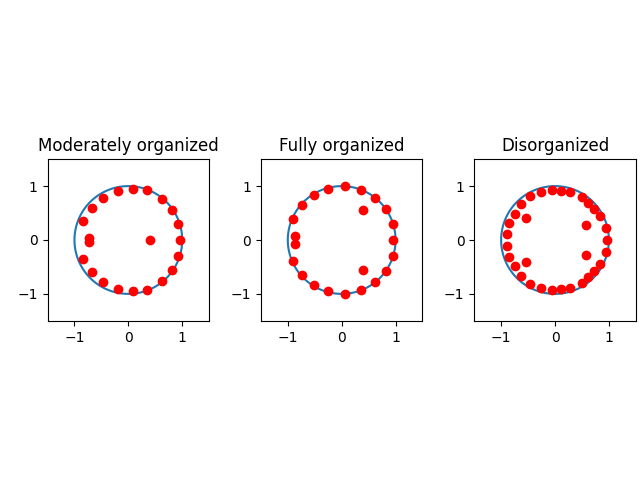

In [52]:
roots = []

for seg in segments:
    
    ys = af_sync[seg[0]:seg[1]]
    
    aro, _, _ = ar_order(ys, nmax)
    rho, _ = yule_walker(ys, order=int(aro), method="mle")
    
    rho = np.concatenate((-rho[::-1], np.array([1])), axis=0)
    roots.append(1 / np.roots(rho))

fig = plt.figure(constrained_layout=True)
t = np.linspace(0, 2*np.pi, 1000)
titles = ['Moderately organized', 'Fully organized', 'Disorganized']

for k in range(3):
    plt.subplot(1,3,k+1)
    plt.plot(np.cos(t), np.sin(t))
    plt.plot(np.real(roots[k]), np.imag(roots[k]), 'ro')
    plt.axis('square')
    plt.xlim([-1.5, 1.5])
    plt.ylim([-1.5, 1.5])
    plt.title(titles[k])

plt.show()

And the proximity to the unit circle can be further summarized in terms of the average magnitude:

In [53]:
for kr in range(len(roots)):
    print(titles[kr] + ': {:.3f}'.format(np.mean(np.abs(roots[kr]))))

Moderately organized: 0.902
Fully organized: 0.951
Disorganized: 0.894


**Question 2.3.** Comment on how signal organization relates to pole location (proximity to the circle).

**Answer 2.3.** `In the course we have seen that a signal is stable if the poles are inside the unit circle. We also have the means of each of the plots: Moderately organized: 0.902
Fully organized: 0.951
Disorganized: 0.894.
Looking at the plots, we observe that when the signal is fully organized, the poles are almost on top of the circle and have a value proximal to 1; that when the signal is moderately organized they lie a little bit on the inside part of the circle; and that when it is disorganized they are far from the circle, they locate at points smaller than 1. 
`

### Experiment 3: recovering the excitation (whitening filter)
The signal in `speech.dat` corresponds to the spoken sound */a/*, sampled at 8 kHz. Used in language, we expect this signal to be clearly structured. We start by importing and plotting it:

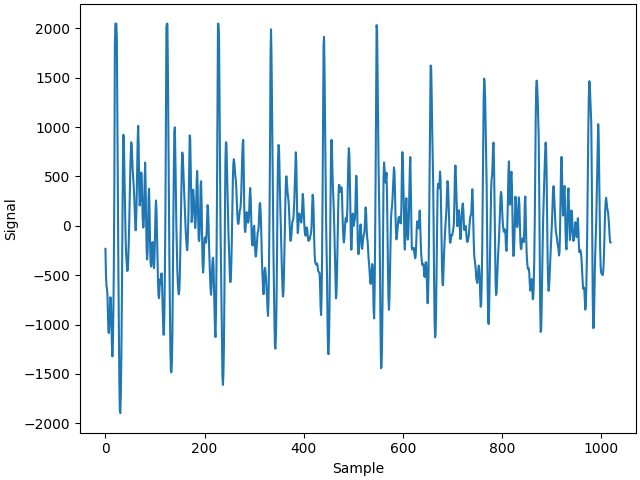

In [54]:
with open(fspc, 'r') as f:
    txt = f.readlines()
    speech = np.array([float(s[:-1]) for s in txt])

speech -= np.mean(speech)

fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(speech)
plt.xlabel('Sample')
plt.ylabel('Signal')
plt.show()

Using the functions `ar_order` and `yule_walker` introduced before, we can estimate the optimal model order for this signal, and then the corresponsing model parameters:

In [55]:
aro1, _, _ = ar_order(speech, 40)
rho1, sgm1 = yule_walker(speech, order=int(aro1), method="mle")

#### The underlying excitation signal
In the framework of AR modeling, the excitation signal driving the observed speech signal can be estimated using a filtering step as follows:

In [56]:
exc1 = lfilter(np.concatenate(([1], -rho1), axis=0), [1], speech)

**Question 3.1.** Explain why the excitation can be estimated in this way.

**Answer 3.1.** `The excitation can be estimated in this way because in an AR model the current value of the observed signal, x(n), is a weighted sum of its past values plus a white noise excitation signal e(n): i.e a convolution in the time domain or a multiplication in the frequency domain of a transfer function H(z). 

In order words, we consider the output, measured signal x as being the result of an excitation signal passed through a "filter" since filtering is essentially just a convolution. This means X(Z)=H(Z)E(Z) or by rearranging, E(Z)=F(Z)X(Z) with F(Z)=1/H(Z) being the new "filter". 

The coefficients of the filter H(Z) were previously calculated as being the AR coefficients (H(Z)=1/(1+a1z^(-1)+a2z^(-2)+...)). 

So here the filter we apply is simply the inverse of H, hence why the numerator is now the (1+a1z^(-1)+a2z^(-2)+...)) and the denominator is 1. This means that the frequencies related to the zeros of this filter will be attenuated (we essentially take the signal and remove the parts of the signal that depend on past values of it so that we are left with just the noise/excitation signal).`

We can now visualize the estimated excitation signal:

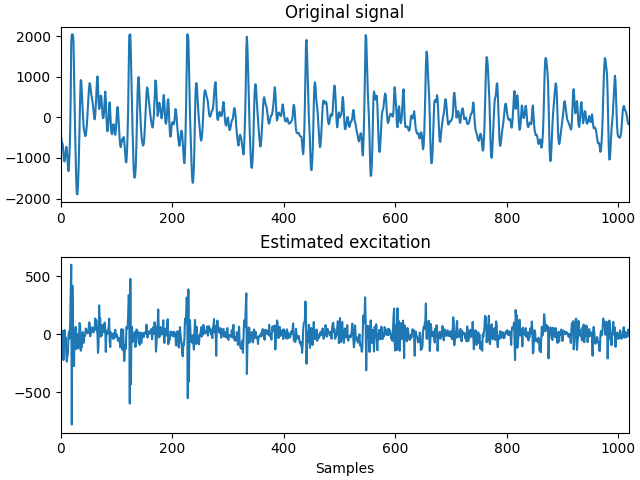

In [57]:
fig = plt.figure(constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(speech)
plt.title('Original signal')
plt.xlim(0, len(speech))

plt.subplot(2,1,2)
plt.plot(exc1)
plt.title('Estimated excitation')
plt.xlim(0, len(speech))
plt.xlabel('Samples')
plt.show()

**Question 3.2.** Compare the excitation with the speech signal. Does the excitation look like white noise?

**Answer 3.2.** `The excitation signal doesn't look completely like white noise, there seems to be a recurring frequency. This is seen as a repeated common peak in intensity in both the noise and the original signal, decreasing in amplitude in both cases. However it is not so clear, especially towards the end of the signal where the peaks are still present in the original signal but not in the estimated noise signal.`

We can test more objectively whether the excitation is indeed similar to white noise by looking at its normalized autocorrelation, as follows:

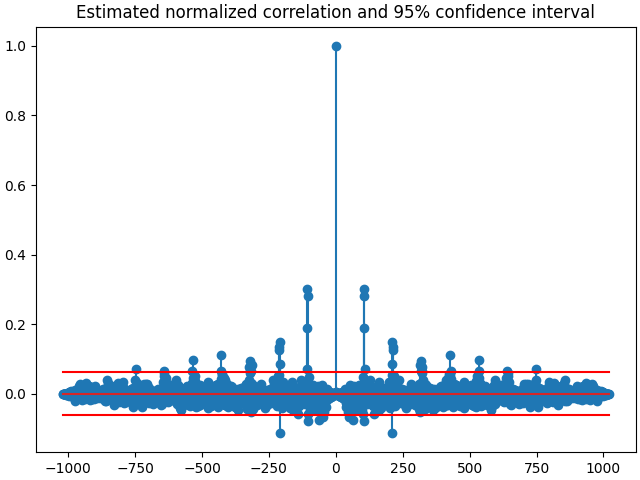

Proportion above 5% threshold: 0.022571


In [58]:
def test_white(x, Aff=0):
    """
    Computation of the ratio of normalized autocorrelation estimates 
    larger than a 5% threshold
    x: signal
    Aff: 0 no graphic display; 1 display
    """
    
    K = len(x)
    
    # Calculate the biased autocorrelation of the signal
    v = np.correlate(x, x, mode='full') / K
    # Note: K-1 is the index for zero lag
    
    thresh = 1.96 / np.sqrt(K)
    pc = np.sum(np.abs(v[K:] / v[K-1]) > thresh) / (K-1)
    
    if Aff == 1:
        fig = plt.figure(constrained_layout=True)
        ml = min(K, K-1)
        lags = range(-ml, ml + 1)
        corr = v[K-1 - ml : K-1 + ml + 1] / v[K-1]
        plt.stem(lags, corr)
        plt.plot([-ml, ml], [+thresh, +thresh], 'r')
        plt.plot([-ml, ml], [-thresh, -thresh], 'r')
        plt.title('Estimated normalized correlation and 95% confidence interval')
        plt.show()

    return pc

print("Proportion above 5% threshold: {:f}".format(test_white(exc1, Aff=1)))

**Question 3.3.** What can we say based on this result?

**Answer 3.3.** `From this result, we can see that only 2.4% of the signal is above the 5% threshold (95% confidence interval for white noise): i.e only 2.4% of the signal is likely to be not random and statistically significant. 

It is clear that there are a few peaks of correlation, which are those seen in the graph. 

All in all it seems like the signal is mostly white noise but with some small correlation (some determinism present).

**N.B:** With the original maximal lag choice (ml=min(30,K-1)) none of the values outside the interval were observed since the autocorrelation was only plotted for a maximal lag of 30 samples. By modifying it to the maximum number of samples, we found the plot to be more easily interpretable.`

We now consider a different example: a timeseries of daily blood systolic pressure recorded from a patient, stored in `blood.dat`:

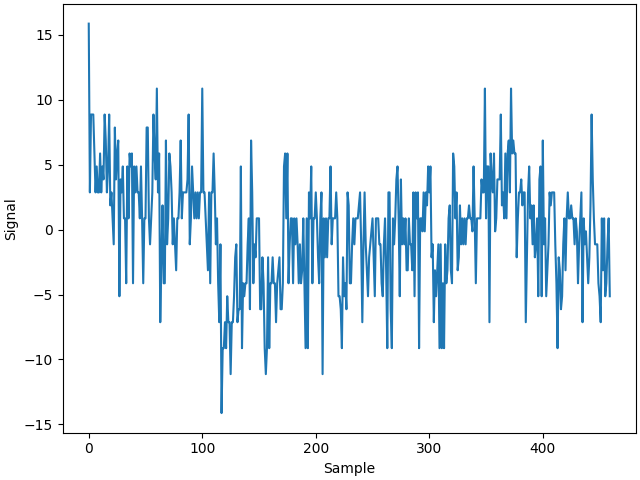

In [59]:
with open(fbld, 'r') as f:
    txt = f.readlines()
    txt = [s[:-1].split() for s in txt]
    blood = np.array([float(s[0]) for s in txt])

blood -= np.mean(blood)

fig = plt.figure(constrained_layout=True)
ax = plt.axes()
plt.plot(blood)
plt.xlabel('Sample')
plt.ylabel('Signal')
plt.show()

**Question 3.4.** Repeat the full analysis done for the speech signal (i.e. estimating AR order, model parameters, excitation signal, whiteness test). How does this excitation signal compare to that of the speech example?

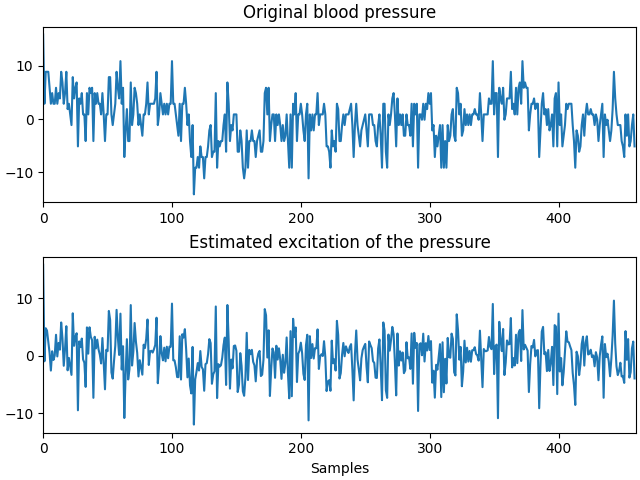

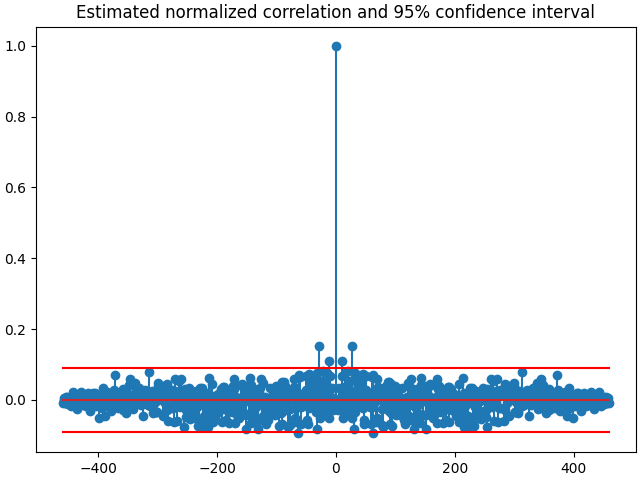

Proportion above 5% threshold: 0.006536


In [60]:
#Answer 3.4: First we define the order and estimate the model parameters using the Yule-Walker method:
aro2, _, _ = ar_order(blood, 50)
rho2, sgm2 = yule_walker(blood, order=int(aro2), method="mle")

# filter it out to find the excitation
exc2 = lfilter(np.concatenate(([1], -rho2)), [1], blood, axis=0)

# Plot the estimated excitation and original signal:
fig = plt.figure(constrained_layout=True)
plt.subplot(2,1,1)
plt.plot(blood)
plt.title('Original blood pressure')
plt.xlim(0, len(blood))

plt.subplot(2,1,2)
plt.plot(exc2)
plt.title('Estimated excitation of the pressure')
plt.xlim(0, len(blood))
plt.xlabel('Samples')
plt.show()

#For starters, the original signal itself appears considerably less deterministic than the speech signal.
#Likewise, the excitation signal appears to be even more characteristic of a white noise (completely stochastic signal) than the speech excitation. There is no clear pattern visible

#Take a look at the autocorrelation for the excitation signal:
print("Proportion above 5% threshold: {:f}".format(test_white(exc2, Aff=1)))

#Compared to the autocorrelation of the speech excitation, the blood pressure excitation shows only 0.6% of the signal outside the confidence interval: i.e it is almost 100% stochastic (white noise).

### Have a good session, and don't hesitate to ask questions!